In [1]:
using Flight
using Flight.FlightLib.Linearization: delete_vars
using Flight.FlightLib.Control.Discrete: PIDParams, LQRParams
using ControlSystems, RobustAndOptimalControl, Plots, UnPack, ComponentArrays, LinearAlgebra

includet("robot2d.jl"); using .Robot2D

## 1. Open Loop Dynamics

In [2]:
mdl = Robot2D.Vehicle() |> Model
lss = linearize(mdl)
P = named_ss(lss)

NamedStateSpace{Continuous, Float64}
A = 
 -2.0209997423344506  40.419994846689    64.81333998969338   0.0
  0.3652409172893585  -7.30481834578717  -4.624109636691573  0.0
  1.0                  0.0                0.0                0.0
  0.0                  1.0                0.0                0.0
B = 
 -34.217985055398096
   6.183973202782789
   0.0
   0.0
C = 
 1.0                    0.0                  0.0                 0.0
 0.0                    1.0                  0.0                 0.0
 0.0                    0.0                  1.0                 0.0
 0.0                    0.0                  0.0                 1.0
 0.0                    0.0                  0.0                 0.0
 0.005843854676629732  -0.11687709353259468  0.2202137458129348  0.0
D = 
 0.0
 0.0
 0.0
 0.0
 1.0
 0.09894357124452458

Continuous-time state-space model
With state  names: ω v θ η
     input  names: m
     output names: ω v θ η u_m τ_m


In [3]:
dampreport(P)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| -3.38              |  1            |  3.38         |  0.537        |  0.296        |
| +6.71              |  -1           |  6.71         |  1.07         |  -0.149       |
| -12.7              |  1            |  12.7         |  2.01         |  0.079        |


## 2. Velocity Controller

In [4]:
#reduced system with η removed
lss_red = delete_vars(lss, :η)
P_red = named_ss(lss_red)

NamedStateSpace{Continuous, Float64}
A = 
 -2.0209997423344506  40.419994846689    64.81333998969338
  0.3652409172893585  -7.30481834578717  -4.624109636691573
  1.0                  0.0                0.0
B = 
 -34.217985055398096
   6.183973202782789
   0.0
C = 
 1.0                    0.0                  0.0
 0.0                    1.0                  0.0
 0.0                    0.0                  1.0
 0.0                    0.0                  0.0
 0.005843854676629732  -0.11687709353259468  0.2202137458129348
D = 
 0.0
 0.0
 0.0
 1.0
 0.09894357124452458

Continuous-time state-space model
With state  names: ω v θ
     input  names: m
     output names: ω v θ u_m τ_m


In [ ]:
P_v, params_v2m = let lss = lss_red

    x_trim = lss.x0
    n_x = length(x_trim)
    x_labels = collect(keys(x_trim))
    @assert tuple(x_labels...) === propertynames(Robot2D.XController())

    u_trim = lss.u0
    n_u = length(u_trim)
    u_labels = collect(keys(u_trim))
    @assert tuple(u_labels...) === propertynames(Robot2D.UController())

    z_labels = [:v, ]
    z_trim = lss.y0[z_labels]
    n_z = length(z_labels)
    @assert tuple(z_labels...) === propertynames(Robot2D.ZController())

    A = lss.A
    B = lss.B
    C = lss.C[z_labels, :]
    D = lss.D[z_labels, :]

    C_int = C[z_labels, :]
    D_int = D[z_labels, :]
    n_int, _ = size(C_int)

    A_aug = [A zeros(n_x, n_int); C_int zeros(n_int, n_int)]
    B_aug = [B; D_int]
    C_aug = [C zeros(n_z, n_int)]
    D_aug = D

    P_aug = ss(A_aug, B_aug, C_aug, D_aug)

    x_aug_labels = push!(copy(x_labels), :ξ_v)
    Q_diag = ComponentVector(zeros(length(x_aug_labels)), Axis(x_aug_labels))
    R_diag = ComponentVector(zeros(length(u_labels)), Axis(u_labels))

    Q_diag.ω = 1e-3
    Q_diag.v = 1e-2
    Q_diag.θ = 0
    Q_diag.ξ_v = 5e-2

    R_diag.m = 1e-1

    Q = diagm(Q_diag)
    R = diagm(R_diag)

    #compute gain matrix
    K_aug = lqr(P_aug, Q, R)

    L = [A B; C D]
    M = inv(L)
    M_12 = M[1:n_x, n_x+1:end]
    M_22 = M[n_x+1:end, n_x+1:end]

    #extract system state and integrator blocks from the feedback matrix
    K_x = K_aug[:, 1:n_x]
    K_ξ = K_aug[:, n_x+1:end]

    K_fbk = K_x
    K_fwd = M_22 + K_x * M_12
    K_int = K_ξ

    K_fbk_ss = named_ss(ss(K_fbk), u = x_labels, y = :m_fbk)
    K_fwd_ss = named_ss(ss(K_fwd), u = :v_ref, y = :m_fwd)
    K_int_ss = named_ss(ss(K_int), u = :v_err, y = :m_int_in)

    int_ss = named_ss(ss(tf(1, [1,0])) .* I(1),
                        x = :m_ξ,
                        u = :m_int_in,
                        y = :m_int_out);

    v_sum = sumblock("v_err = v - v_ref")
    m_sum = sumblock("m = m_fwd - m_fbk - m_int_out")

    connections = vcat(
        Pair.(x_labels, x_labels),
        :v_err => :v_err,
        :m_int_in=> :m_int_in,
        :m_int_out => :m_int_out,
        :m_fwd => :m_fwd,
        :m_fbk => :m_fbk,
        :m => :m,
        )

        #connect back to full plant
    P_v = connect([P, int_ss, K_fwd_ss, K_fbk_ss, K_int_ss,
                    v_sum, m_sum], connections;
                    w1 = :v_ref, z1 = P.y, unique = false)

    params = LQRDataPoint(;
        K_fbk = Matrix(K_fbk), K_fwd = Matrix(K_fwd), K_int = Matrix(K_int),
        x_trim = Vector(x_trim), u_trim = Vector(u_trim), z_trim = Vector(z_trim))

    (P_v, params)

end

nothing

In [6]:
dampreport(P_v)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| -0.584             |  1            |  0.584        |  0.093        |  1.71         |
| -3.48              |  1            |  3.48         |  0.553        |  0.288        |
| -6.29              |  1            |  6.29         |  1            |  0.159        |
| -13.4              |  1            |  13.4         |  2.14         |  0.0745       |


StepInfo:
Initial value:     0.000
Final value:       1.023
Step size:         1.023
Peak:              1.165
Peak time:         1.283 s
Overshoot:         13.90 %
Undershoot:        27.45 %
Settling time:     3.894 s
Rise time:         0.360 s


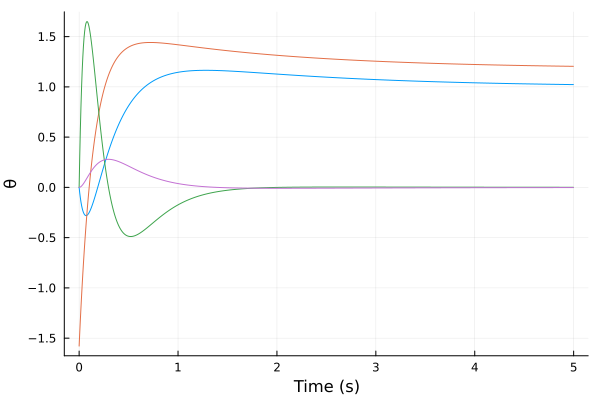

In [7]:
t_sim = 5
step(P_v[:v, :v_ref], t_sim) |> stepinfo |> display
step(P_v[:v, :v_ref], t_sim) |> plot
step(P_v[:u_m, :v_ref], t_sim) |> plot!
step(P_v[:ω, :v_ref], t_sim) |> plot!
step(P_v[:θ, :v_ref], t_sim) |> plot!
# step(P_v[:η, :v_ref], t_sim) |> plot!

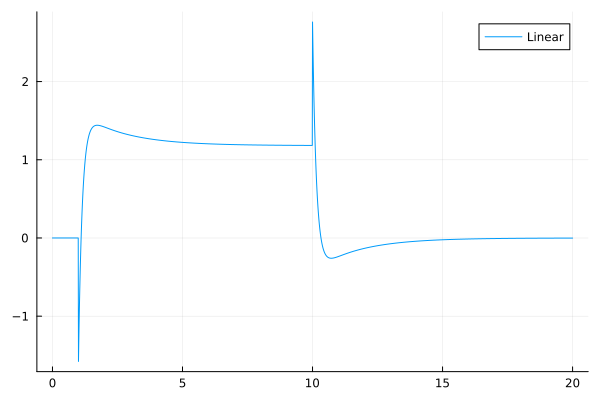

In [28]:
#simulate a unit velocity command input applied from t=1 to t = 5
y, t, _, _ = lsim(P_v[:u_m, :v_ref], (x, t)->[1.0]*(1<=t<10), 0:0.01:20)
plot(t, vec(y); label = "Linear")

This shows that stopping the vehicle requires a transient increase in motor input.
Therefore, to ensure we always leave sufficient control authority to stop the vehicle, we should
limit the velocity reference input to a fraction of the maximum steady state
velocity, that is, the steady state velocity corresponding to the maximum motor input.

## 3. Position Controller

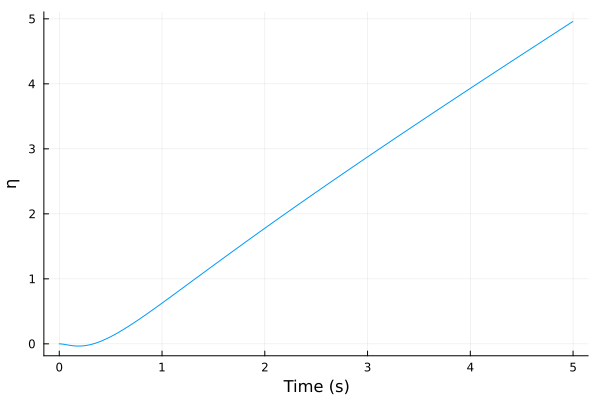

In [18]:
P_v2η = P_v[:η, :v_ref]
step(P_v2η, t_sim) |> plot

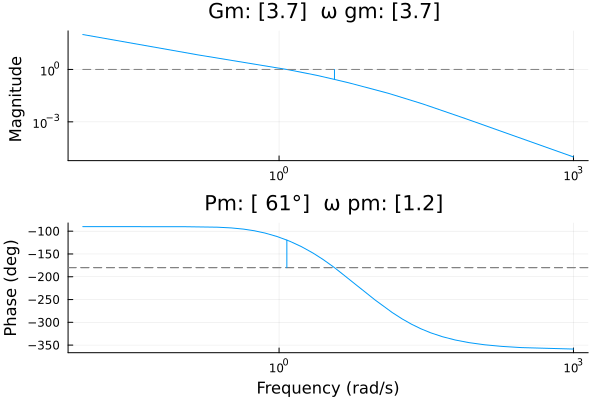

In [9]:
marginplot(P_v2η)

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

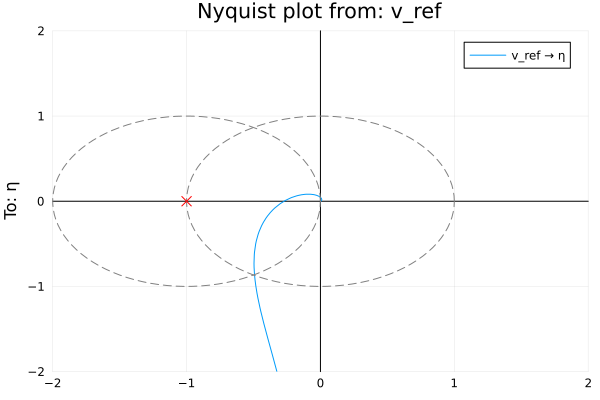

In [10]:
nyquistplot(P_v2η; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

In [11]:
k_p_η2v = 0.6
C_η2v = named_ss(ss(k_p_η2v), :C_η2v; u = :η_err, y = :v_ref);
L_η2v = series(C_η2v, P_v2η);

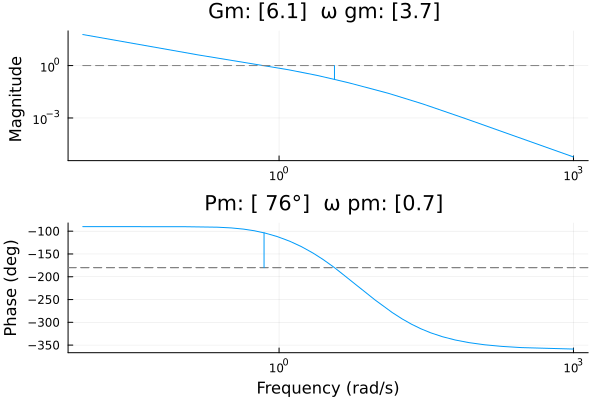

In [12]:
marginplot(L_η2v)

StepInfo:
Initial value:     0.000
Final value:       0.992
Step size:         0.992
Peak:              0.992
Peak time:         9.995 s
Overshoot:          0.00 %
Undershoot:         2.08 %
Settling time:     6.490 s
Rise time:         2.165 s


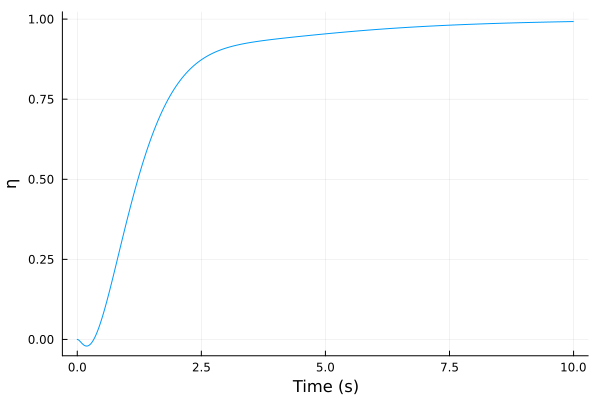

In [19]:
#closed loop transfer function
T_η2v = output_comp_sensitivity(P_v2η, C_η2v)
T_η2v_step_SISO = step(T_η2v, 2t_sim)
stepinfo(T_η2v_step_SISO) |> display
T_η2v_step_SISO |> plot

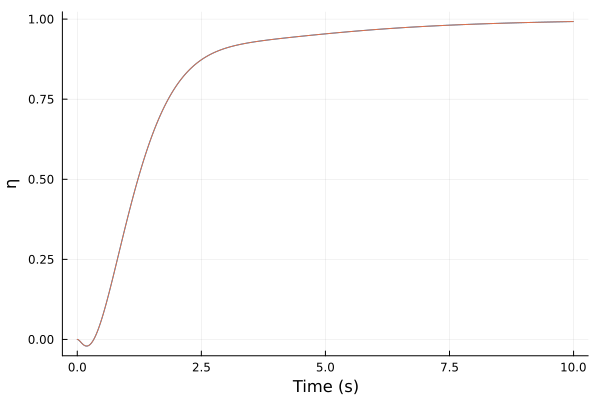

In [20]:
#connect the position loop
η2v_sum = sumblock("η_err = η_ref - η")
P_η = connect([P_v, η2v_sum, C_η2v], [:η_err=>:η_err, :η=>:η, :v_ref=>:v_ref], w1 = [:η_ref, ], z1 = P_v.y)

#verify the response matches that of the SISO closed loop
step(P_η[:η, :η_ref], 2t_sim) |> plot
T_η2v_step_SISO |> plot!

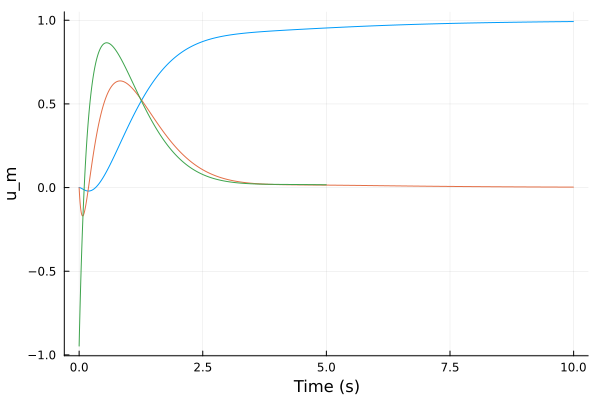

In [29]:
step(P_η[:η, :η_ref], 2t_sim) |> plot
step(P_η[:v, :η_ref], 2t_sim) |> plot!
step(P_η[:u_m, :η_ref], t_sim) |> plot!
# step(P_η[:ω, :η_ref], t_sim) |> plot!
# step(P_η[:θ, :η_ref], t_sim) |> plot!